# Introduction

Conformal prediction is a framework in supervised machine learning that provides a measure of confidence or uncertainty for individual predictions. Traditional ML algorithms provide a way to learning the underlying patterns in the data. In addition to this, conformal prediction provides a way to quantify uncertainty in predictions made by a ML model. Concretely, instead of outputing a single point estimate, conformal prediction provides prediction intervals or sets, indicating the range of possible outcomes along with a measure of confidence associated with each prediction. 

This framework is particularly useful in scenarios where understanding the uncertainty associated with predictions is crucial, such as in medical diagnosis, financial forecasting, or safety-critical systems.

Below are the steps to apply conformal prediction:

1. **Training Phase**. In the training phase, the model is trained on a labeled dataset just like any other supervised learning algorithm.

2. **Calibration Phase**. After training, the model enters a calibration phase where it learns how to assign confidence levels to its predictions. This is done using a calibration set, which is typically a portion of the training data that the model hasn't seen before. The model generates predictions for this calibration set and assesses its own reliability by comparing its predictions to the actual outcomes.

3. **Conformal Prediction Phase**. Once the model is calibrated, it can be used to make predictions on new, unseen data. For each prediction, the model doesn't just output a single point estimate, but rather a prediction set or interval along with a confidence level. This prediction set contains all possible outcomes that the model deems plausible, based on its training and calibration.

5. **Evaluation**. The performance of a conformal prediction model can be evaluated based on how well the predicted intervals match the actual outcomes. Metrics such as coverage probability (the proportion of actual outcomes within the predicted intervals) and width of the intervals can be used to assess the model's reliability and calibration.

More formally, given a test example $\mathbf{x}_{m+1}$ and a user-specified significance level $\alpha \in (0,1)$, a conformal predictor outputs a prediction region that contains the true output value with probability $1-\alpha$. The value $(1-\alpha)$ is called **confidence level**.

# A Simple Example

In [31]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# Calibrate the classifier to get probabilities
calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid', cv='prefit')
calibrated_clf.fit(X_train, y_train)

# Now let's implement conformal prediction for each test instance
prediction_intervals = []

for instance, true_label in zip(X_test, y_test):
    # Get class probabilities for the instance
    probabilities = calibrated_clf.predict_proba([instance])[0]
    
    # Calculate p-values for each class
    p_values = [1 - probabilities[i] for i in range(len(probabilities))]
    
    # Define significance level (alpha) - you can adjust this based on your needs
    alpha = 0.05
    
    # Calculate the size of the prediction interval based on the p-values
    k = int(np.floor(alpha * len(p_values))) + 1
    
    # Extract the k smallest p-values
    smallest_p_values = sorted(p_values)[:k]
    
    # Determine the prediction interval
    lower_bound = min(smallest_p_values)
    upper_bound = max(smallest_p_values)
    
    prediction_intervals.append((lower_bound, upper_bound))

# Now you have prediction intervals for each test instance
# You can use these intervals along with the actual labels to evaluate the performance of conformal prediction


In [32]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# Calibrate the classifier to get probabilities
calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid', cv='prefit')
calibrated_clf.fit(X_train, y_train)

# Select a single test example
test_instance = X_test[0]
true_label = y_test[0]

# Get class probabilities for the test example
probabilities = calibrated_clf.predict_proba([test_instance])[0]

# Calculate p-values for each class
p_values = [1 - probabilities[i] for i in range(len(probabilities))]

# Define significance level (alpha) - you can adjust this based on your needs
alpha = 0.05

# Calculate the size of the prediction interval based on the p-values
k = int(np.floor(alpha * len(p_values))) + 1

# Extract the k smallest p-values
smallest_p_values = sorted(p_values)[:k]

# Determine the prediction interval
lower_bound = min(smallest_p_values)
upper_bound = max(smallest_p_values)

# Print the prediction interval and the true label
print("Prediction Interval:", (lower_bound, upper_bound))
print("True Label:", true_label)

Prediction Interval: (0.021691180653692466, 0.021691180653692466)
True Label: 1


# Case Study

In [33]:
import pandas as pd

df = pd.read_csv('../data/insurance.csv')

In [34]:
df.region.unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [35]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [36]:
df1 = pd.get_dummies(df, drop_first=True)
df1.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


In [37]:
df = df1

In [38]:
target_column_name = 'charges'
train_percentage = 0.7
cal_percentage = 0.2
X = df.drop(columns=[target_column_name]).to_numpy()
Y = df[target_column_name].to_numpy()
n_total = X.shape[0]
n_train = int(train_percentage*n_total)
n_cal = int(cal_percentage*n_total) + n_train
train_data = X[:n_train, :]
train_target = Y[:n_train]
cal_data = X[n_train:n_cal, :]
cal_target = Y[n_train:n_cal]
test_data = X[n_cal:, :]
test_target = Y[n_cal:]

In [39]:
test_data.shape

(135, 8)

In [40]:
#pip install nonconformist

In [41]:
# pip install lightgbm

In [42]:
x_train = train_data
y_train = train_target

x_cal = cal_data
y_cal = cal_target

x_test = test_data
y_test = test_target

In [43]:
from nonconformist.cp import IcpRegressor
from nonconformist.cp import IcpClassifier
from nonconformist.nc import NcFactory
import lightgbm as lgbm
# Create the underlying model
model = lgbm.LGBMRegressor()
# Default nonconformity measure
nc = NcFactory.create_nc(model)
# Inductive conformal regressor
icp = IcpRegressor(nc)
# Fit the ICP using the proper training set
icp.fit(x_train, y_train)
# Calibrate the ICP using the calibration set
icp.calibrate(x_cal, y_cal)
# Desired coverage
confidence = 0.8
# Produce predictions for the test set
prediction = icp.predict(x_test, significance=(1-confidence))
lower_b = prediction[:, 0]
upper_b = prediction[:, 1]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 936, number of used features: 8
[LightGBM] [Info] Start training from score 13113.527470


In [44]:
prediction.shape

(135, 2)

In [45]:
upper_b - lower_b 

array([8359.13412558, 8359.13412558, 8359.13412558, 8359.13412558,
       8359.13412558, 8359.13412558, 8359.13412558, 8359.13412558,
       8359.13412558, 8359.13412558, 8359.13412558, 8359.13412558,
       8359.13412558, 8359.13412558, 8359.13412558, 8359.13412558,
       8359.13412558, 8359.13412558, 8359.13412558, 8359.13412558,
       8359.13412558, 8359.13412558, 8359.13412558, 8359.13412558,
       8359.13412558, 8359.13412558, 8359.13412558, 8359.13412558,
       8359.13412558, 8359.13412558, 8359.13412558, 8359.13412558,
       8359.13412558, 8359.13412558, 8359.13412558, 8359.13412558,
       8359.13412558, 8359.13412558, 8359.13412558, 8359.13412558,
       8359.13412558, 8359.13412558, 8359.13412558, 8359.13412558,
       8359.13412558, 8359.13412558, 8359.13412558, 8359.13412558,
       8359.13412558, 8359.13412558, 8359.13412558, 8359.13412558,
       8359.13412558, 8359.13412558, 8359.13412558, 8359.13412558,
       8359.13412558, 8359.13412558, 8359.13412558, 8359.13412

In [46]:
y_pred = (lower_b+upper_b)/2

In [23]:
y_pred.shape

(135,)

In [47]:
y_test.shape, prediction[:,1].shape, lower_b.shape, upper_b.shape

((135,), (135,), (135,), (135,))

In [48]:
# taken from MAPIE docs

def sort_y_values(y_test, y_pred, lower_b, upper_b):
    """
    Sorting the dataset in order to make plots using the fill_between function.
    """
    indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[indices]
    y_pred_sorted = y_pred[indices]
    y_lower_bound = lower_b[indices]
    y_upper_bound = upper_b[indices]
    return y_test_sorted, y_pred_sorted, y_lower_bound, y_upper_bound

In [49]:
(y_test_sorted, y_pred_sorted, lower_bound_sorted, upper_bound_sorted) = sort_y_values(y_test, y_pred, lower_b, upper_b)

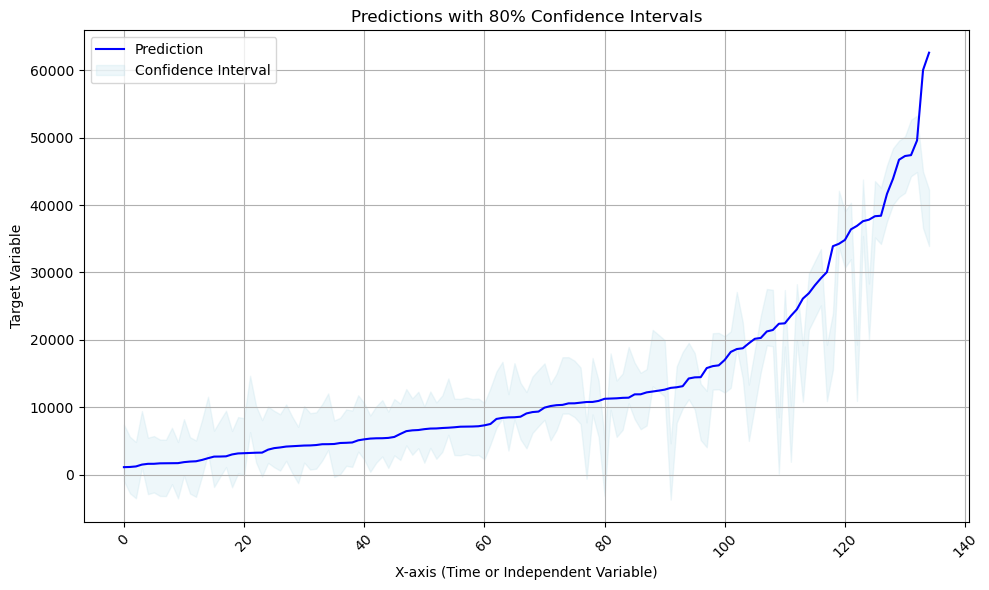

In [50]:
import matplotlib.pyplot as plt

x_test = range(len(prediction))

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(x_test, y_test_sorted, label="Prediction", color="blue")
plt.fill_between(x_test, lower_bound_sorted, upper_bound_sorted, alpha=0.2, label="Confidence Interval", color="lightblue")

# Enhance plot aesthetics
plt.xlabel("X-axis (Time or Independent Variable)")  # Set meaningful x-axis label
plt.ylabel("Target Variable")  # Set meaningful y-axis label
plt.title("Predictions with 80% Confidence Intervals")
plt.legend()

# Customize plot for clarity
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(True)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

# References

## Books
1. Vovk, V., Gammerman, A., & Shafer, G. (2022). [Algorithmic Learning in a Random World](https://alrw.net). An [excerpt](https://download.e-bookshelf.de/download/0000/0004/78/L-G-0000000478-0002330810.pdf).

## Papers
1. [A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification](https://arxiv.org/abs/2107.07511), by Anastasios N. Angelopoulos and Stephen Bates

## Videos
1. [Three Easy Steps to Understand Conformal Prediction (CP), Conformity Score, Python Implementation](https://youtu.be/oqK6rM8fbkk), by Dr. Data Science channel
2. [A Tutorial on Conformal Prediction](https://youtu.be/nql000Lu_iE), by Anastasios Nikolas Angelopoulos
3. [Conformal Prediction Tutorial](https://youtu.be/0MsGri8nmJQ), by Henrik Linusson
4. [Maria Navarro: Quantifying uncertainty in Machine Learning predictions | PyData London 2019](https://youtu.be/r6bhm_A-YcQ)
5. [Emmanuel Candès - A Taste of Conformal Prediction](https://www.youtube.com/watch?v=YzTzN3RyFrk)

Misc
1. [Wikipedia entry for 'Quantile'](https://en.wikipedia.org/wiki/Quantile)
2. [Conformal Prediction: An easy way to estimate prediction intervals](https://medium.com/bain-inside-advanced-analytics/conformal-prediction-an-easy-way-to-estimate-prediction-intervals-c0de34c47494)
3. [Are sample quantiles consistent with population quantiles?](https://stats.stackexchange.com/questions/637467/are-sample-quantiles-consistent-with-population-quantiles)
4. [Conformal Prediction: An easy way to estimate prediction intervals](https://medium.com/bain-inside-advanced-analytics/conformal-prediction-an-easy-way-to-estimate-prediction-intervals-c0de34c47494)
5. [Getting Started With Conformal Prediction For Classification](https://mindfulmodeler.substack.com/p/week-1-getting-started-with-conformal)
6. [An Introduction to Conformal Prediction](https://cml.rhul.ac.uk/copa2017/presentations/CP_Tutorial_2017.pdf)
7. [Percentile vs quantile vs quartile (What is the difference between the three terms?) ](https://stats.stackexchange.com/questions/156778/percentile-vs-quantile-vs-quartile)